<a href="https://colab.research.google.com/github/biniyam-mulugeta/final/blob/main/Final_K-fold_Softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd

In [6]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/phoma_cro/456_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_5.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_6.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_7.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_8.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/460.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461_1.jpg
/content/dr

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

In [9]:
from keras.utils.all_utils import to_categorical
y_train_one_hot = to_categorical(y_train)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,y_train,test_size=0.20,shuffle=True,random_state=42,stratify=y_train)

In [12]:
print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(5653, 32, 32, 3) ---- (5653,)
(1414, 32, 32, 3) ---- (1414,)


In [13]:
#x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

In [14]:
shape = (32,32,3)

In [15]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [16]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [17]:
input_layer = Input(shape=shape)

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(8, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

In [18]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [19]:
inp = Input(shape = shape)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(8,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

In [20]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.340)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = output)
e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [22]:
e_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 16)   448         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d_12[0][0]']              
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

In [23]:
skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
#skfolds = KFold(n_splits=3)

In [24]:
score = []
i = 0
for trainset,testset in skfolds.split(x_tr,y_tr):
    predicted_targets = np.array([])
    actual_targets = np.array([])
    accuracy_list = list()
    predicted_train_targets = np.array([])
    actual_train_targets = np.array([])
    accuracy_train_list = list()
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

    x_tra,x_val=x_tr[trainset],x_tr[testset]
    y_trin,y_val=y_tr[trainset],y_tr[testset]
    y_tra_oh = to_categorical(y_trin)
    y_val_oh = to_categorical(y_val)

    y_tra_oh_r = np.argmax(y_tra_oh,axis=-1)
    y_val_oh_r = np.argmax(y_val_oh,axis=-1)

    e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = e_model.fit([x_tra,x_tra],y_tra_oh,epochs=200,validation_data=([x_val,x_val],y_val_oh))

    predicted_labels = e_model.predict([x_val,x_val])
    predicted_labels_round = np.argmax(predicted_labels,axis=-1)

    accuracy = accuracy_score(y_val_oh_r, predicted_labels_round)
    
    predicted_t_labels = e_model.predict([x_tra,x_tra])
    predicted_t_labels_round = np.argmax(predicted_t_labels,axis=-1)
    accuracy_t = accuracy_score(y_tra_oh_r, predicted_t_labels_round)
    
    predicted_targets = np.append(predicted_targets, predicted_labels_round)
    actual_targets = np.append(actual_targets, y_val_oh_r)
    accuracy_list.append(accuracy)
    
    predicted_train_targets = np.append(predicted_train_targets, predicted_t_labels_round)
    actual_train_targets = np.append(actual_train_targets, y_tra_oh_r)
    accuracy_train_list.append(accuracy_t)

    score.append(history)
    print("iteration", i)
    i+=1

folds  0
[   0    2    4 ... 5649 5651 5652] having : 3768
[   1    3    8 ... 5645 5648 5650] having : 1885
Epoch 1/200
118/118 [==============================] - 9s 31ms/step - loss: 1.8115 - accuracy: 0.3331 - val_loss: 1.2220 - val_accuracy: 0.5671
Epoch 2/200
118/118 [==============================] - 3s 23ms/step - loss: 1.0447 - accuracy: 0.5565 - val_loss: 0.7441 - val_accuracy: 0.6589
Epoch 3/200
118/118 [==============================] - 3s 23ms/step - loss: 0.7647 - accuracy: 0.6545 - val_loss: 0.5638 - val_accuracy: 0.7284
Epoch 4/200
118/118 [==============================] - 2s 21ms/step - loss: 0.6496 - accuracy: 0.7075 - val_loss: 0.4982 - val_accuracy: 0.7316
Epoch 5/200
118/118 [==============================] - 2s 21ms/step - loss: 0.5781 - accuracy: 0.7306 - val_loss: 0.4641 - val_accuracy: 0.7517
Epoch 6/200
118/118 [==============================] - 2s 21ms/step - loss: 0.5300 - accuracy: 0.7410 - val_loss: 0.4596 - val_accuracy: 0.7554
Epoch 7/200
118/118 [======

### plot curve of each fold

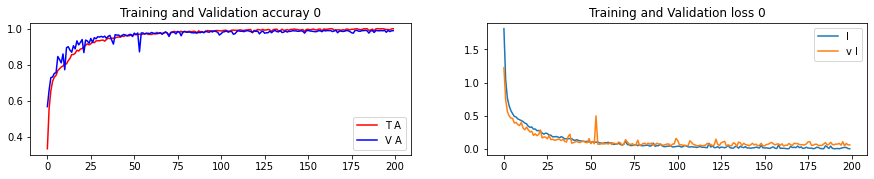

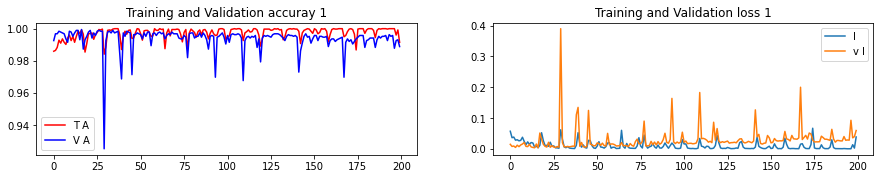

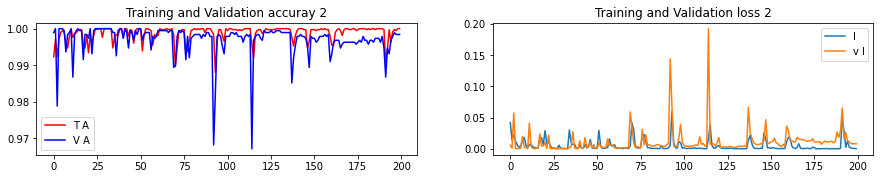

In [25]:
for i in range(3):
    acc = score[i].history['accuracy']
    loss = score[i].history['loss']
    val_acc = score[i].history['val_accuracy']
    val_loss = score[i].history['val_loss']
  #acc = history.history['accuracy']
  #val_acc = history.history['val_accuracy']
  #loss = history.history['loss']
  #val_loss = history.history['val_loss']
    plt.figure(figsize=(15,8))
    epochs = range(len(acc))
    plt.subplot(321)
    plt.plot(epochs, acc, 'r', label = 'T A')
    plt.plot(epochs, val_acc, 'b', label= 'V A')
    plt.title(f'Training and Validation accuray {i}')
    plt.legend(loc=0)
  #plt.figure(figsize=(10,5))
    plt.subplots_adjust(wspace=0.2,bottom=0.1)

    plt.subplot(322)
    plt.plot(epochs, loss,'', label = 'l')
    plt.plot(epochs, val_loss,'', label = 'v l')
    plt.title(f'Training and Validation loss {i}')
    plt.legend(loc=0)
  #plt.figure(figsize=(10,5))
    plt.subplots_adjust(wspace=0.2)
  #show the graph
plt.show()

### mean score of Kfold cross validation

In [26]:
 acc1 = score[0].history['accuracy']
 acc2 = score[1].history['accuracy']
 acc3 = score[2].history['accuracy']
 val1 = score[0].history['val_accuracy']
 val2 = score[1].history['val_accuracy']
 val3 = score[2].history['val_accuracy']
 loss1 = score[0].history['loss']
 loss2 = score[1].history['loss']
 loss3 = score[2].history['loss']
 val_loss1 = score[0].history['val_loss']
 val_loss2 = score[1].history['val_loss']
 val_loss3 = score[2].history['val_loss']

In [27]:
acur = [(acc1 + acc2 +acc3) / 3 for acc1,acc2,acc3 in zip(acc1,acc2,acc3)]
val = [(val1 + val2 +val3) / 3 for val1,val2,val3 in zip(val1,val2,val3)]
loss = [(loss1 + loss2 +loss3) / 3 for loss1,loss2,loss3 in zip(loss1,loss2,loss3)]
val_loss = [(val_loss1 + val_loss2 +val_loss2) / 3 for val_loss1,val_loss2,val_loss3 in zip(val_loss1,val_loss2,val_loss3)]

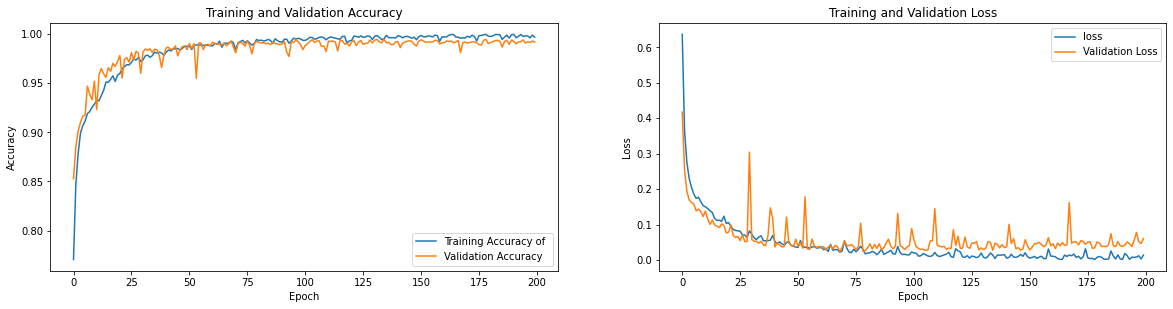

In [28]:
  plt.figure(figsize=(20,15))
  epochs = range(len(acc))
  plt.subplot(321)
  plt.plot(epochs, acur, label = 'Training Accuracy of ')
  plt.plot(epochs, val, label= 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(322)
  plt.plot(epochs, loss, label = 'loss ')
  plt.plot(epochs, val_loss, label= 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

### confusion matrix

In [29]:
labeles = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

In [30]:
actual_train_targets_r = np.argmax(actual_train_targets,axis=-1)
print(actual_train_targets)

[2. 3. 5. ... 4. 0. 0.]


	Training Accuracy : 1.0000


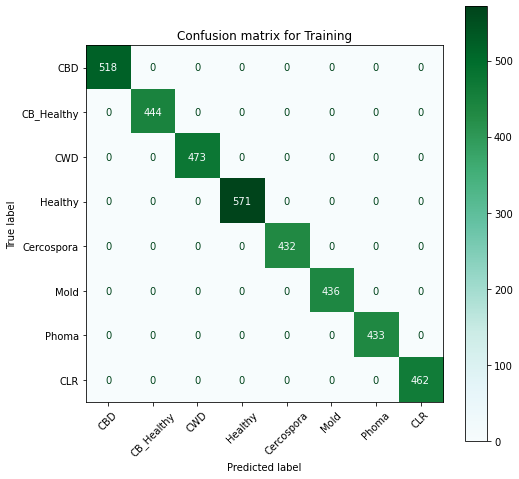

In [31]:
    acc = accuracy_score(predicted_t_labels_round, np.ravel(y_tra_oh_r, order='C'))
    print("\tTraining Accuracy : %0.4f" % acc)

    fig,ax = plt.subplots(figsize=(8,8))

    cm = confusion_matrix(actual_train_targets, predicted_train_targets)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("Confusion matrix for Training")
    plt.show()

	Validation Accuracy : 0.9984


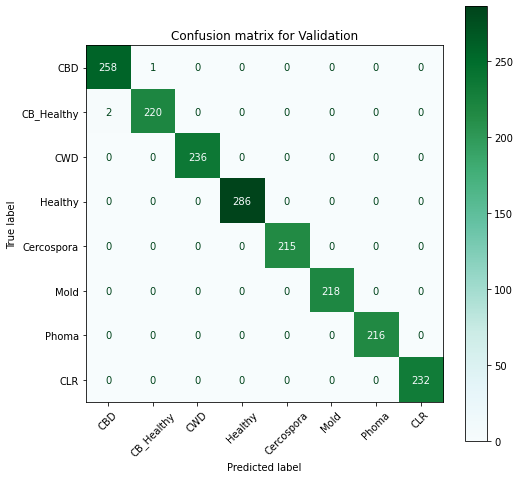

In [32]:
    fig,ax = plt.subplots(figsize=(8,8))
    acc = accuracy_score(predicted_labels_round, np.ravel(y_val_oh_r, order='C'))
    print("\tValidation Accuracy : %0.4f" % acc)
    
    cm = confusion_matrix(actual_targets, predicted_targets)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("Confusion matrix for Validation")
    plt.show()

In [33]:
result = e_model.predict([x_te,x_te])
result_r = np.argmax(result,axis=-1)
print(result_r)
print(y_te)

[4 1 0 ... 5 1 4]
[4 1 0 ... 5 1 4]


In [34]:
result = e_model.predict([x_te,x_te])
result_r = np.argmax(result,axis=-1)
y_teh = to_categorical(y_te)
acc = accuracy_score(result_r, np.ravel(y_te, order='C'))
print("\tTesting Accuracy : %0.4f" % acc)
print(classification_report(y_te,result_r))

	Testing Accuracy : 0.9915
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       195
           1       0.97      0.98      0.98       166
           2       1.00      1.00      1.00       178
           3       1.00      1.00      1.00       214
           4       0.99      0.99      0.99       162
           5       0.99      1.00      1.00       164
           6       0.99      0.99      0.99       162
           7       1.00      0.99      1.00       173

    accuracy                           0.99      1414
   macro avg       0.99      0.99      0.99      1414
weighted avg       0.99      0.99      0.99      1414



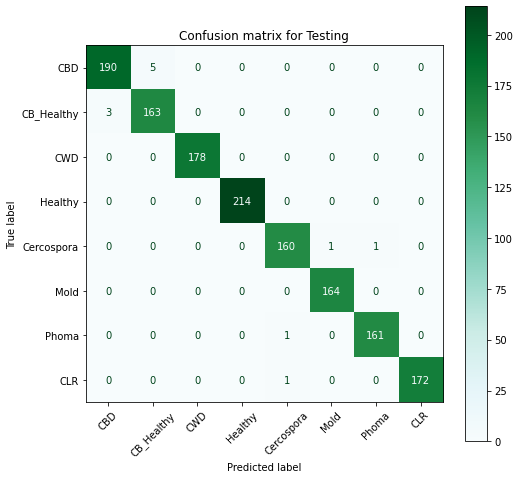

In [35]:
    fig,ax = plt.subplots(figsize=(8,8))
    cm = confusion_matrix(y_te, result_r)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
    disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
    disp.ax_.set_title("Confusion matrix for Testing")
    plt.show()